In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
from scipy.stats import linregress

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [ ]:
# Define a function that creates a set of "n" random lat and lng combinations
def city_set(n):
    
    lats = np.random.uniform(lat_range[0], lat_range[1], size=n)
    lngs = np.random.uniform(lng_range[0], lng_range[1], size=n)
    return zip(lats, lngs)

# Define a function that identifies the nearest city for each lat, lng combination and attempts to add it to our list
def city_add(coord,city_list):
    city = citipy.nearest_city(coord[0], coord[1]).city_name
    if city not in city_list:
        city_list.append(city)

In [112]:
# List for holding cities
cities = []
        
while len(cities) < 20:
    sample = city_set(10)
    for coord in sample:
        city_add(coord,cities)

# Print the city count to confirm sufficient count
len(cities)

27

In [126]:
# Request weather data (temperature, humidity, cloudiness, windspeed) from OpenWeather

cities = []
lat = []
lng = []
temp = []
humidity = []
cloudiness = []
windspeed = []
country = []
date = []

print("-----------------------------------")
print("Retrieving Data – Please be patient")
print("-----------------------------------")


while len(cities) < 5:
    
    sample = city_set(10)
    for coord in sample:
        
        city = citipy.nearest_city(coord[0], coord[1]).city_name
        
        if city not in cities:
            
            # Avoid exceeding 60 calls per minute from API request
            time.sleep(1)
            
            # Request data from API
            city_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units=imperial"
            response = requests.get(city_url).json()
            
            try:
                lat.append(response["coord"]["lat"])
                lng.append(response["coord"]["lon"])
                temp.append(response["main"]["temp_max"])
                humidity.append(response["main"]["humidity"])
                cloudiness.append(response["clouds"]["all"])
                windspeed.append(response["wind"]["speed"])
                country.append(response["sys"]["country"])
                date.append(response["dt"])
                cities.append(city)
                print(f"Found data for city #{len(cities)}: {city}")
                
            except:
                print(f"City '{city}' not found. Proceeding to next city.")
                pass
    
print("-------------------------------------------")
print(f"Successfully retrieved data for {len(cities)} cities.")
print("-------------------------------------------")

-----------------------------------
Retrieving Data – Please be patient
-----------------------------------
Found data for city #1: flin flon
Found data for city #2: kisangani
Found data for city #3: salalah
Found data for city #4: sassandra
Found data for city #5: bengkulu
Found data for city #6: dutse
Found data for city #7: orlik
Found data for city #8: hobart
Found data for city #9: moron
Found data for city #10: oranjemund
-------------------------------------------
Successfully retrieved data for 10 cities.
-------------------------------------------


In [128]:
# Create a dataframe
weather_df = pd.DataFrame({
    "City":cities,
    "Latitude":lat,
    "Longitude":lng,
    "Max Temperature (°F)":temp,
    "Humidity (%)":humidity,
    "Cloudiness (%)":cloudiness,
    "Wind Speed (mph)":windspeed,
    "Country Code":country,
    "Date & Time":date
})

# Extract average timestamp & store for later
mean_date = weather_df["Date & Time"].mean()
retrieval_date = datetime.datetime.fromtimestamp(mean_date).date()

# Export data into a csv
weather_df.to_csv(output_data_file,index = False)


weather_df.head()

,City,Latitude,Longitude,Max Temperature (°F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country Code,Date & Time
0,flin flon,54.7682,-101.8650,-20.20,63,90,16.11,CA,1612819935
1,kisangani,0.5167,25.2000,71.24,54,94,1.48,CD,1612819936
2,salalah,17.0151,54.0924,71.60,73,0,3.44,OM,1612819937
3,sassandra,4.9500,-6.0833,77.72,90,87,6.20,CI,1612819939
4,bengkulu,-3.8004,102.2655,75.63,75,91,5.32,ID,1612819940


## Scatterplots

This scatterplot shows the relationship between Temperature and Latitude of each city.

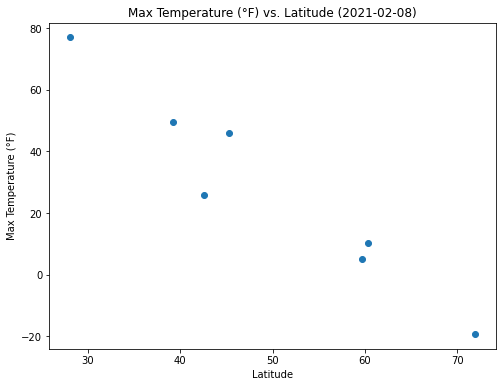

In [129]:
x_values = north_df["Latitude"]
y_str = "Max Temperature (°F)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Temperature_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Humidity and Latitude of each city.

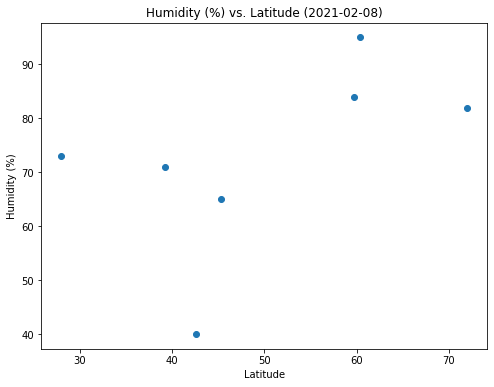

In [130]:
x_values = north_df["Latitude"]
y_str = "Humidity (%)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Humidity_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Cloudiness and Latitude of each city.

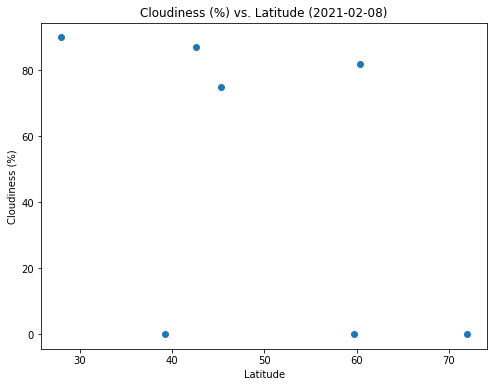

In [131]:
x_values = north_df["Latitude"]
y_str = "Cloudiness (%)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Cloudiness_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Wind Speed and Latitude of each city.

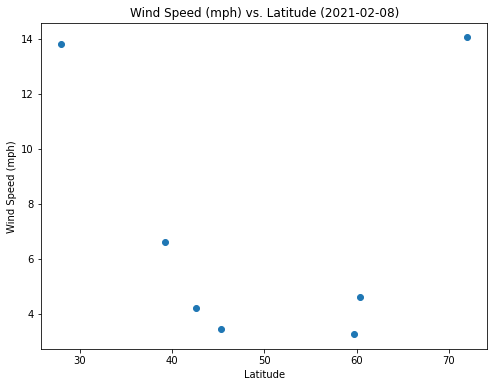

In [132]:
x_values = north_df["Latitude"]
y_str = "Wind Speed (mph)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel(y_str)

plt.savefig("output_data/Wind_Speed_vs_Latitude.png")
plt.show()

## Linear Regression

To analyze each relationship using linear regression, we will separate the data by hemisphere (since we are exploring whether distance away from the equator, where latitude is zero, is correlated with the weather data).

In [133]:
# Create a DataFrame for each hemisphere

north_df = weather_df.loc[weather_df["Latitude"]>0]

south_df = weather_df.loc[weather_df["Latitude"]<0]

#### Northern Hemisphere: Temperature vs. Latitude

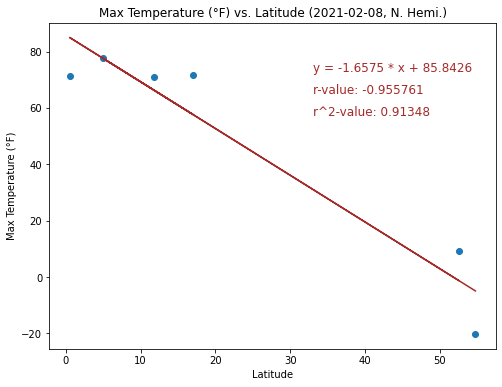

In [134]:
x_values = north_df["Latitude"]
y_str = "Max Temperature (°F)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Temperature_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Temperature vs. Latitude

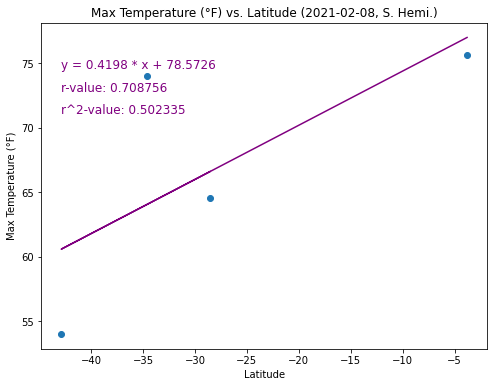

In [135]:
x_values = south_df["Latitude"]
y_str = "Max Temperature (°F)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Temperature_vs_Latitude_South.png")
plt.show()

In [136]:
# Analysis here after testing

#### Northen Hemisphere: Humidity vs. Latitude

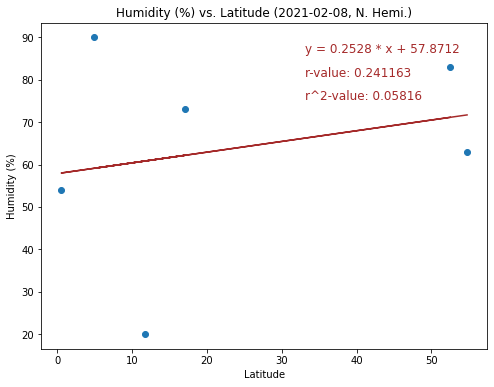

In [137]:
x_values = north_df["Latitude"]
y_str = "Humidity (%)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Humidity_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Humidity vs. Latitude

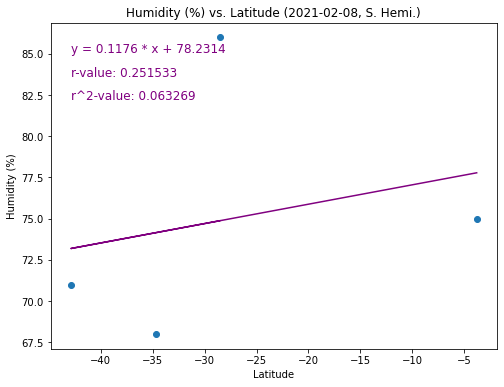

In [138]:
x_values = south_df["Latitude"]
y_str = "Humidity (%)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Humidity_vs_Latitude_South.png")
plt.show()

In [139]:
# Analysis Later

#### Northern Hemisphere: Cloudiness vs. Latitude

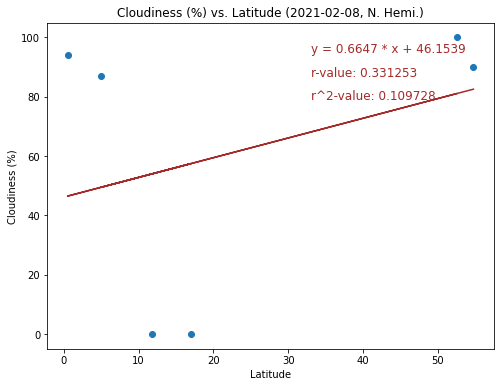

In [140]:
x_values = north_df["Latitude"]
y_str = "Cloudiness (%)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Cloudiness_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Cloudiness vs. Latitude

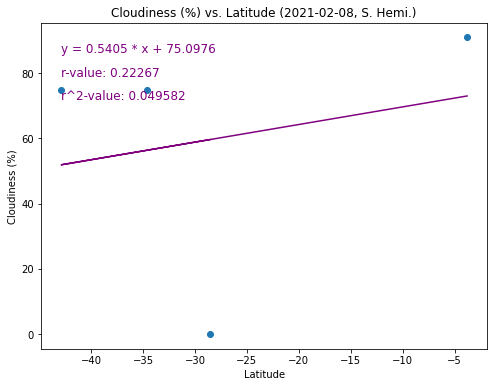

In [141]:
x_values = south_df["Latitude"]
y_str = "Cloudiness (%)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Cloudiness_vs_Latitude_South.png")
plt.show()

In [142]:
# Analysis Later

#### Northern Hemisphere: Wind Speed vs. Latitude

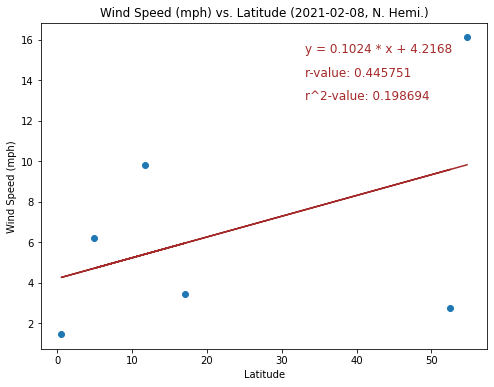

In [143]:
x_values = north_df["Latitude"]
y_str = "Wind Speed (mph)"
y_values = north_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Wind_Speed_vs_Latitude_North.png")
plt.show()

#### Southern Hemisphere: Wind Speed vs. Latitude

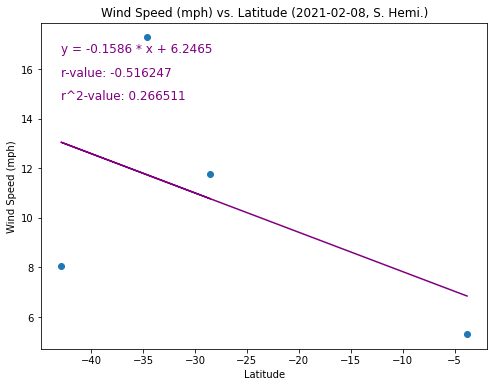

In [144]:
x_values = south_df["Latitude"]
y_str = "Wind Speed (mph)"
y_values = south_df[y_str]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'{y_str} vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel(y_str)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Wind_Speed_vs_Latitude_South.png")
plt.show()

In [145]:
# Analysis Later